This code implements a U-Net model for image segmentation, specifically for satellite image processing. It includes custom metrics (F1 Score and IoU), data preprocessing, and training pipeline. Here's a breakdown:

    Custom Metrics:
        F1ScoreMetric: Calculates the F1 score using precision and recall.
        IoUMetric: Computes the Intersection over Union (IoU) for multiple classes.

    U-Net Model:
        A deep learning model with an encoder-decoder structure.
        Uses convolutional layers, max-pooling, upsampling, and skip connections.
        The final layer applies a softmax activation to predict multi-class segmentation masks.

    Data Preprocessing:
        parse_image(): Reads, resizes, and normalizes BMP images and PNG masks.
        Converts RGBA masks to class indices based on predefined colors and applies one-hot encoding.

    Dataset Handling:
        load_dataset(): Loads images and masks into a TensorFlow dataset for efficient training.
        split_dataset(): Splits data into training and validation sets.

    Training & Evaluation:
        train_unet():
            Loads the dataset.
            Creates and compiles the U-Net model with Adam optimizer and categorical cross-entropy loss.
            Trains the model using the training set and validates on the validation set.
        plot_predictions(): Displays sample input images, ground truth masks, and predicted masks

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 38s 889ms/step - accuracy: 0.6787 - f1_score: 0.0474 - iou: 0.6225 - loss: 1.0439 - val_accuracy: 0.7434 - val_f1_score: 0.0000e+00 - val_iou: 0.6086 - val_loss: 0.8652
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 833ms/step - accuracy: 0.6795 - f1_score: 0.0000e+00 - iou: 0.6086 - loss: 0.9552 - val_accuracy: 0.7434 - val_f1_score: 0.0000e+00 - val_iou: 0.6086 - val_loss: 0.7792
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 837ms/step - accuracy: 0.6795 - f1_score: 0.0000e+00 - iou: 0.6086 - loss: 0.9303 - val_accuracy: 0.7434 - val_f1_score: 0.0000e+00 - val_iou: 0.6086 - val_loss: 0.7159
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 26s 835ms/step - accuracy: 0.6814 - f1_score: 0.0136 - iou: 0.6245 - loss: 0.7845 - val_accuracy: 0.7440 - val_f1_score: 0.0927 - val_iou: 0.6586 - val_loss: 0.6294
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 27s 872ms/step - accuracy: 0.7130 - f1_score: 0.3142 - iou: 0.7523 - loss: 0.6782 - val_accuracy: 0.7435 - val_f1_score: 0.1693 - 

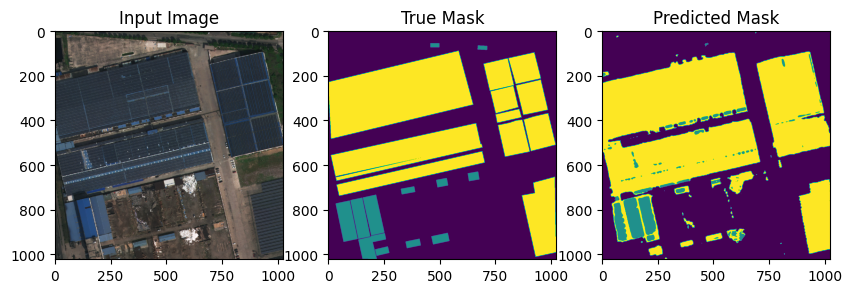

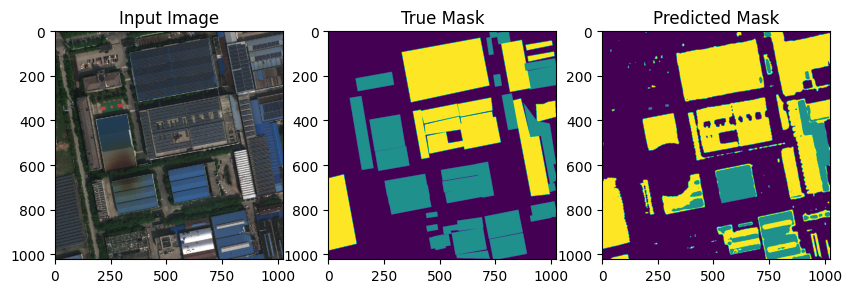

In [ ]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

# Define class names
class_names = ['Background', 'Class1', 'Class2']  # Replace these names based on your classes

# Custom metric class for F1 Score
class F1ScoreMetric(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='f1_score', **kwargs):
        super(F1ScoreMetric, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.precision_metric = tf.keras.metrics.Precision()
        self.recall_metric = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        self.precision_metric.update_state(y_true, y_pred)
        self.recall_metric.update_state(y_true, y_pred)

    def result(self):
        precision = self.precision_metric.result()
        recall = self.recall_metric.result()
        return 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

    def reset_states(self):
        self.precision_metric.reset_states()
        self.recall_metric.reset_states()

class IoUMetric(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='iou', **kwargs):
        super(IoUMetric, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.total_iou = self.add_weight(name="total_iou", initializer="zeros", shape=(num_classes,))
        self.count = self.add_weight(name="count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert one-hot encoded labels to class indices
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)

        batch_iou = []

        for i in range(self.num_classes):
            # Create binary masks for each class
            y_true_class = tf.cast(tf.equal(y_true, i), tf.float32)
            y_pred_class = tf.cast(tf.equal(y_pred, i), tf.float32)

            # Calculate intersection and union
            intersection = tf.reduce_sum(y_true_class * y_pred_class)
            union = tf.reduce_sum(y_true_class + y_pred_class) - intersection

            # Avoid division by zero and calculate IoU
            iou = intersection / (union + tf.keras.backend.epsilon())

            # Clip IoU values to avoid exceeding 1
            iou = tf.clip_by_value(iou, 0.0, 1.0)
            batch_iou.append(iou)

        # Convert IoUs to a tensor and normalize using L2 normalization
        batch_iou = tf.convert_to_tensor(batch_iou)
        l2_norm = tf.sqrt(tf.reduce_sum(tf.square(batch_iou))*0.3 + tf.keras.backend.epsilon())
        normalized_iou = (batch_iou) / l2_norm

        # Accumulate normalized IoUs
        self.total_iou.assign_add(normalized_iou)
        self.count.assign_add(1)

    def result(self):
        # Compute the average IoU
        average_iou = self.total_iou / (self.count + tf.keras.backend.epsilon())
        return tf.reduce_mean(average_iou)

    def reset_states(self):
        # Reset the accumulated values
        self.total_iou.assign(tf.zeros_like(self.total_iou))
        self.count.assign(0)
   

# Define the U-Net model
def unet_model(input_size=(1024, 1024, 3), num_classes=3):
    inputs = tf.keras.layers.Input(input_size)
    conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    up6 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5)
    merge6 = tf.keras.layers.concatenate([conv4, up6], axis=3)
    conv6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    merge7 = tf.keras.layers.concatenate([conv3, up7], axis=3)
    conv7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    merge8 = tf.keras.layers.concatenate([conv2, up8], axis=3)
    conv8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    merge9 = tf.keras.layers.concatenate([conv1, up9], axis=3)
    conv9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', F1ScoreMetric(num_classes=num_classes), IoUMetric(num_classes=num_classes)])
    return model

# Function to parse images and masks
def parse_image(image_path, mask_path, num_classes):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_bmp(image, channels=3)
    image = tf.image.resize(image, (1024, 1024))
    image = tf.cast(image, tf.float32) / 255.0  # Min-max normalization

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=4)  # Decode as RGBA
    mask = tf.image.resize(mask, (1024, 1024))
    mask = tf.cast(mask, tf.uint8)

    # Convert mask to class indices based on the unique colors
    mask_indices = tf.where(tf.reduce_all(tf.equal(mask, [0, 0, 0, 255]), axis=-1), 0,
                             tf.where(tf.reduce_all(tf.equal(mask, [130, 201, 138, 255]), axis=-1), 1,
                             tf.where(tf.reduce_all(tf.equal(mask, [253, 120, 179, 255]), axis=-1), 2, 0)))
    mask = tf.one_hot(mask_indices, num_classes)

    return image, mask

# Function to load the dataset
def load_dataset(image_dir, mask_dir, batch_size, num_classes):
    image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.bmp')])
    mask_paths = sorted([os.path.join(mask_dir, fname) for fname in os.listdir(mask_dir) if fname.endswith('.png')])
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(lambda x, y: parse_image(x, y, num_classes), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Function to split the dataset
def split_dataset(dataset, split_ratio=0.8):
    total_size = sum(1 for _ in dataset)
    train_size = int(total_size * split_ratio)
    train_dataset = dataset.take(train_size)
    val_dataset = dataset.skip(train_size)
    return train_dataset, val_dataset

# Function to plot predictions
def plot_predictions(model, dataset, num_images=3):
    images, masks = next(iter(dataset.take(1)))
    predictions = model.predict(images)

    for i in range(min(num_images, images.shape[0])):
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(images[i])
        plt.title('Input Image')

        plt.subplot(1, 3, 2)
        plt.imshow(tf.argmax(masks[i], axis=-1))
        plt.title('True Mask')

        plt.subplot(1, 3, 3)
        plt.imshow(tf.argmax(predictions[i], axis=-1))
        plt.title('Predicted Mask')

        plt.show()

# Training the U-Net model
def train_unet(image_dir, mask_dir, batch_size=2, epochs=20):
    num_classes = len(class_names)  # Use the number of class names defined earlier
    dataset = load_dataset(image_dir, mask_dir, batch_size, num_classes)
    train_dataset, val_dataset = split_dataset(dataset)

    model = unet_model(input_size=(1024, 1024, 3), num_classes=num_classes)
    model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

    plot_predictions(model, val_dataset, num_images=3)

# Example usage
image_dir = '/kaggle/input/sattelite/satellite image _/actual_2'
mask_dir = '/kaggle/input/sattelite/satellite image _/SegmentationClass'
train_unet(image_dir, mask_dir)
